In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import pysindy as ps
import matplotlib.pyplot as plt

from tqdm import tqdm

import sys
sys.path.insert(0, '/project/vitelli/jonathan/REDO_fruitfly/src')

warnings.filterwarnings('ignore')

100%|██████████| 6/6 [00:00<00:00, 12.08it/s]


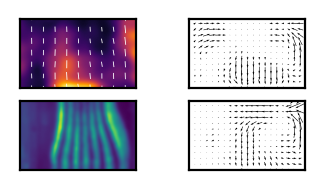

In [2]:
from utils.dataset import *
from utils.plot_utils import *
from utils.vae.training import train_val_split
from torchvision.transforms import Compose

transform = Compose([
    Reshape2DField(),
    ToTensor()
])

sqh_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'tensor2D', 
                           transform=transform, drop_time=True)
sqh_vel_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'velocity2D', 
                               transform=transform, drop_time=True)

sqh_dataset = TrajectoryDataset([
    ('m_ij', sqh_dataset),
    ('v', sqh_vel_dataset),
], 
ensemble=6)

rnt = AtlasDataset('WT', 'Runt', 'raw2D', 
    transform=Compose([Reshape2DField(), Smooth2D(sigma=3), ToTensor()]))
rnt_vel = AtlasDataset('WT', 'Runt', 'velocity2D', 
    transform=Compose([Reshape2DField(), ToTensor()]))

rnt_dataset = TrajectoryDataset([
    ('rnt', rnt),
    ('vel', rnt_vel)
], live_key='vel')


fig, ax = plt.subplots(2, 2, dpi=200, figsize=(2, 1))
batch = sqh_dataset[130]
plot_tensor2D(ax[0,0], batch['m_ij'][0].numpy())
plot_vector2D(ax[0,1], batch['v'][0])

batch = rnt_dataset[130]
color_2D(ax[1,0], batch['rnt'][0].numpy())
plot_vector2D(ax[1,1], batch['vel'][0])

In [3]:
from utils.vae.convnext_models import *

info = torch.load('../../tb_logs/November2023/MaskedVAE_Evolver_sqh_beta=0_split=embryo')
print('Loss = ', info['loss'])
sqh_model = MaskedVAE_Evolver(**info['hparams'])
sqh_model.load_state_dict(info['state_dict'], strict=False);

info = torch.load('../../tb_logs/November2023/MaskedVAE_Evolver_rnt_beta=0_split=embryo')
print('Loss = ', info['loss'])
rnt_model = MaskedVAE_Evolver(**info['hparams'])
rnt_model.load_state_dict(info['state_dict'], strict=False);

Loss =  0.05839801260403223
Loss =  0.24752273478291253


In [5]:
def ensemble_key(dataset, key, time):
    df = dataset.df[dataset.df.key == key]
    nearest = df[(df.time - time).abs() < 1]

    frame = []
    for i, row in nearest.iterrows():
        data = dataset.values[row.embryoID][key][row.eIdx]
        if dataset.transforms[row.dataset_idx] is not None:
            data = dataset.transforms[row.dataset_idx](data)
        frame.append(data)

    if torch.is_tensor(frame[0]):
        frame = torch.mean(torch.stack(frame), dim=0)
    elif isinstance(frame[0], np.ndarray):
        frame = np.mean(np.stack(frame), axis=0)

    return frame

def get_ensemble_trajectory(dataset, tmin, tmax):
    times = np.arange(tmin, tmax, dtype=int)
    sample = {}
    for key in dataset.keys:
        sample[key] = []
        for t in times:
            sample[key].append(ensemble_key(dataset, key, t))
    
        sample[key] = torch.stack(sample[key], dim=0)
    sample['time'] = times
    return sample

from math import floor, ceil
from scipy.interpolate import RectBivariateSpline as interp2d

def get_velocity(v, tt, X0, Y0, x, y):
    idxA, idxB = floor(tt), ceil(tt)
    frac = 1 - (tt - idxA)
    vA, vB = v[idxA], v[idxB]
        
    vx = interp2d(Y0, X0, frac * vA[1] + (1 - frac) * vB[1])(y, x, grid=False)
    vy = interp2d(Y0, X0, frac * vA[0] + (1 - frac) * vB[0])(y, x, grid=False)
    return vx, vy

def rk4DynamicVelocity2D(pts, X0v, Y0v, v, hh):
    tt = np.arange(0, v.shape[0]-1, hh)
    xyPathsMat = np.zeros([pts.shape[0], len(tt), 2])

    x = pts[:, 0]
    y = pts[:, 1]
    xyPathsMat[:, 0, 0] = x
    xyPathsMat[:, 0, 1] = y
    
    Xmin, Xmax = X0v[0], X0v[-1]
    Ymin, Ymax = Y0v[0], Y0v[-1]
    
    for ii in range(len(tt) - 1):
        k1x, k1y = get_velocity(v, tt[ii], X0v, Y0v, x, y)
        k2x, k2y = get_velocity(v, tt[ii] + 0.5 * hh, X0v, Y0v, x + 0.5 * hh * k1x, y + 0.5 * hh * k1y)
        k3x, k3y = get_velocity(v, tt[ii] + 0.5 * hh, X0v, Y0v, x + 0.5 * hh * k2x, y + 0.5 * hh * k2y)
        k4x, k4y = get_velocity(v, tt[ii] + hh, X0v, Y0v, x + hh * k3x, y + hh * k3y)
        
        #Main equation
        x = x + (k1x + 2 * k2x + 2 * k3x + k4x) * hh / 6.
        y = y + (k1y + 2 * k2y + 2 * k3y + k4y) * hh / 6.
        
        x[x > Xmax] = Xmax
        x[x < Xmin] = Xmin
        y[y > Ymax] = Ymax
        y[y < Ymin] = Ymin
        
        xyPathsMat[:, ii, 0] = x
        xyPathsMat[:, ii, 1] = y
            
    return xyPathsMat

nDV, nAP = 10, 10
DV = np.linspace(dv_min, dv_max, nDV)
AP = np.linspace(ap_min, ap_max, nAP)

hh = 0.2
DV += 0.5 * (dv_max - DV[-1])
AP += 0.5 * (ap_max - AP[-1])
pts = np.stack(np.meshgrid(AP, DV, indexing='xy'), axis=-1).reshape([-1, 2])

DV = np.linspace(dv_min, dv_max, 236)
AP = np.linspace(ap_min, ap_max, 200)

tmin, tmax = 0, 15
sqh_batch = get_ensemble_trajectory(sqh_dataset, tmin, tmax)
rnt_batch = get_ensemble_trajectory(rnt_dataset, tmin, tmax)
device = torch.device('cuda:0')
sqh_model.eval()
sqh_model.to(device)

rnt_model.eval()
rnt_model.to(device)
with torch.no_grad():
    #x = torch.cat([batch['m_ij'], batch['c']], dim=1)
        
    x = rnt_batch['rnt']
    y02 = rnt_batch['vel']
    y2, pl = rnt_model(x[0:1].to(device), torch.tensor([x.shape[0]]).to(device))
    y2 = y2[0].cpu().numpy()
    y02 = y02.cpu().numpy()
    
    x = sqh_batch['m_ij']
    y01 = sqh_batch['v']
    y1, pl = sqh_model(x[0:1].to(device), torch.tensor([x.shape[0]]).to(device))
    y1 = y1[0].cpu().numpy()
    y01 = y01.cpu().numpy()
    x = x.cpu().numpy()
    #print(x.shape, y0.shape, y1.shape, y2.shape)
    
    #y0Paths = rk4DynamicVelocity2D(pts, AP, DV, y0, hh)
    #y1Paths  = rk4DynamicVelocity2D(pts, AP, DV, y1,  hh)
    #y2Paths = rk4DynamicVelocity2D(pts, AP, DV, y2, hh)
    #print(y0Paths.shape, y1Paths.shape, y2Paths.shape)

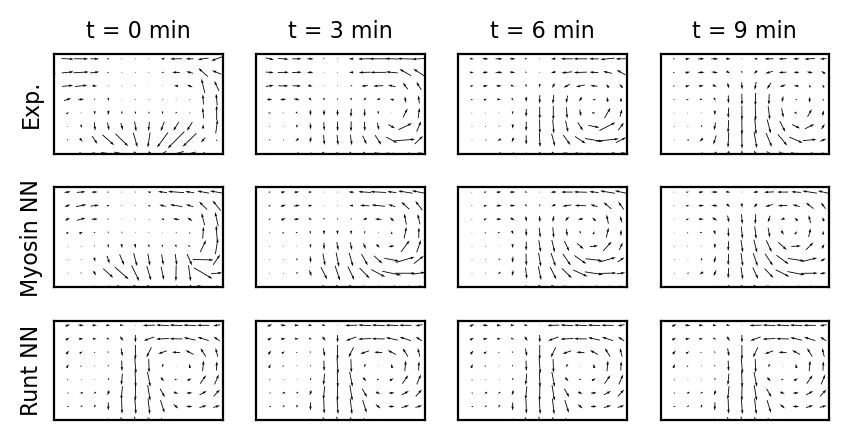

In [8]:
from utils.plot_utils import *
fig, ax = plt.subplots(3, 4, dpi=200, figsize=(5, 2.5))
dt = 3
for i in range(ax.shape[1]):
    plot_vector2D(ax[0, i], y01[dt*i], skip=16)
    plot_vector2D(ax[1, i], y1[dt*i], skip=16)
    plot_vector2D(ax[2, i], y2[dt*i], skip=16)
    
    ax[0,i].set_title(f't = {tmin+dt*i} min', fontsize=8)
    
ax[0,0].set_ylabel('Exp.', fontsize=8)
ax[1,0].set_ylabel('Myosin NN', fontsize=8)
ax[2,0].set_ylabel('Runt NN', fontsize=8)

plt.savefig('Sqh_Runt_TimeSeries.svg', bbox_inches='tight')

In [9]:
y00 = np.mean(np.concatenate([sqh_vel_dataset.values[eId] for eId in sqh_vel_dataset.values], axis=0), axis=0, keepdims=True)
y00 = np.mean(np.concatenate([rnt_vel.values[eId] for eId in rnt_vel.values], axis=0), axis=0, keepdims=True)
y00 = np.repeat(y00, 15, axis=0)


0.072073035 0.14160293 0.259845384220804


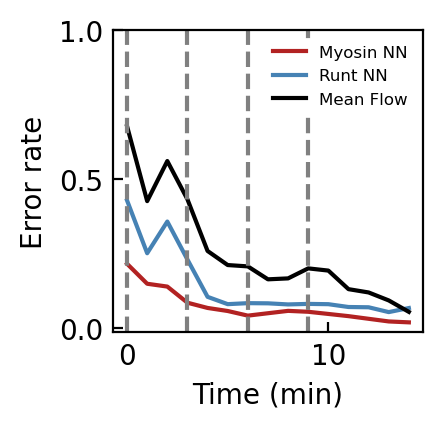

In [12]:
fig, ax = plt.subplots(1, 1, dpi=200, figsize=(2., 2.))


t = np.arange(tmin, tmax)
ax.plot(t, residual(y01, y1).mean(axis=(1, 2)), color='firebrick', label='Myosin NN')
ax.plot(t, residual(y02, y2).mean(axis=(1, 2)), color='steelblue', label='Runt NN')
ax.plot(t, residual(y00, y02).mean(axis=(1, 2)), color='black', label='Mean Flow')

print(np.mean(residual(y01, y1)), np.mean(residual(y02, y2)), np.mean(residual(y00, y02)))

for i in range(4):
    ax.axvline(i*dt+tmin, color='grey', linestyle='--')

ax.set(
    xlabel='Time (min)',
    ylabel='Error rate',
    yticks=[0, 0.5, 1])
ax.legend(framealpha=1, edgecolor='white', fontsize=6)

plt.savefig('Sqh_Runt_ErrorRate.svg', bbox_inches='tight')

(20, 2, 236, 200) (20, 2, 236, 200)


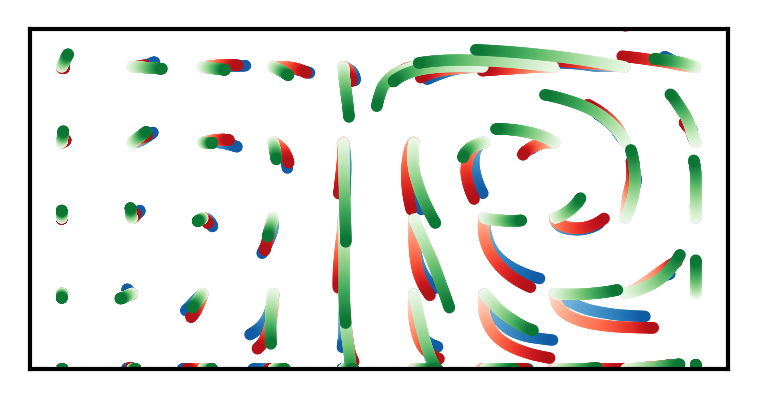

In [9]:
#Demonstrate ensemble of cell trajectories
plt.style.use('Figure1/Figure1.mplstyle')

fig, ax = plt.subplots(1, 1, figsize=(3, 1.5))

labels = ['Experiment', 'Myo.', 'Rnt']
cmaps = [
    'Blues',
    'Reds',
    'Greens'
]
print(y0.shape, y1.shape)
for i, paths in enumerate([y0Paths, y1Paths, y2Paths]):
    nPts = paths.shape[0]
    nTps = paths.shape[1]
    for tpId in range(nTps-1):
        ax.scatter(paths[:, tpId, 0], paths[:, tpId, 1], s=3, 
                   c=np.ones(nPts)*tpId, 
                   cmap=cmaps[i], vmin=-10, vmax=nTps*1.2)
        
ax.set(xticks=[], yticks=[])
ax.set_ylim([dv_min, dv_midpoint])
ax.set_aspect('auto')

#plt.savefig('Figure1/RNN_Forecasting.png')

(20, 2, 236, 200) (20, 2, 236, 200)


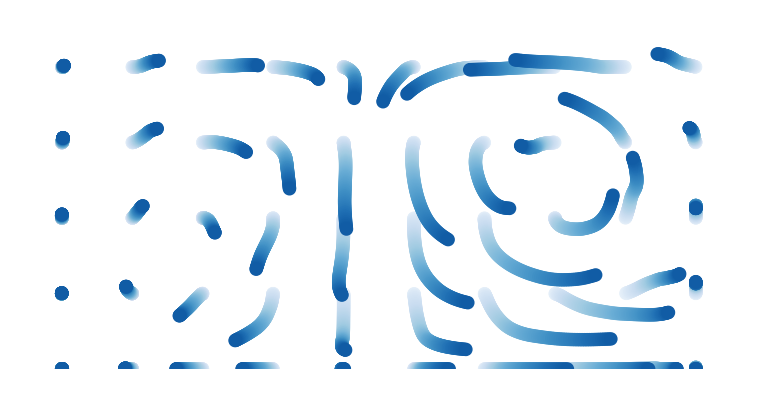

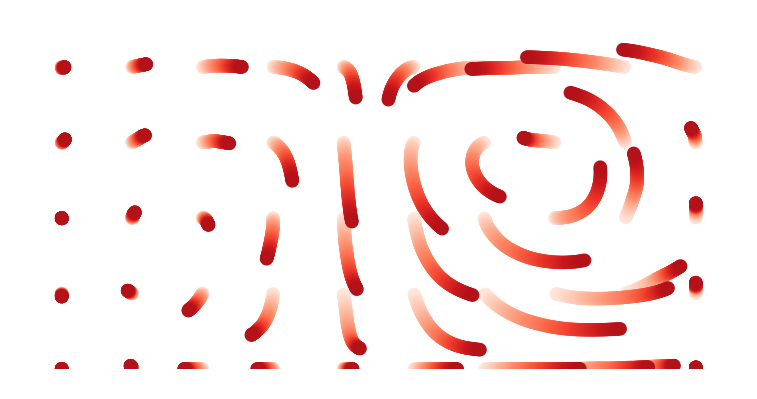

In [47]:
#Demonstrate ensemble of cell trajectories
plt.style.use('Figure1/Figure1.mplstyle')

fig1, ax1 = plt.subplots(1, 1, figsize=(3, 1.5))
fig2, ax2 = plt.subplots(1, 1, figsize=(3, 1.5))
labels = ['Experiment', 'ML']
cmaps = [
    'Blues',
    'Reds',
]
print(y0.shape, y.shape)
i = 0
for ax, paths, in zip([ax1, ax2], [y0Paths, yPaths]):
    nPts = paths.shape[0]
    nTps = paths.shape[1]
    for tpId in range(nTps-1):
        ax.scatter(paths[:, tpId, 0], paths[:, tpId, 1], s=5, 
                   c=np.ones(nPts)*tpId, 
                   cmap=cmaps[i], vmin=-10, vmax=nTps*1.2)
    i += 1

    ax.set(xticks=[], yticks=[])
    ax.set_ylim([dv_min, dv_midpoint])
    ax.set_aspect('auto')
    ax.axis('off')

fig1.savefig('Figure1/EXP_trajectories.png', dpi=350)
fig2.savefig('Figure1/RNN_trajectories.png', dpi=350)